In [ ]:
!pip install textblob wordcloud -q

import pandas as pd
import numpy as np
import re#regular expressions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer#Converts words to their base dictionary form (lemma).movies->movie,running->run
from nltk.tokenize import word_tokenize
from textblob import TextBlob#spell correction
from collections import Counter#for word frequency and 
from nltk.util import ngrams#bigrams and trigrams

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud#to visualize frequent words

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from sklearn.metrics import accuracy_score

# Download necessary NLTK components
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

train_df = pd.read_csv('Train.csv')
val_df = pd.read_csv('Valid.csv')
test_df = pd.read_csv('Test.csv')


/bin/bash: /home/student/miniconda3/envs/tf-gpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


##### Q2 & Q3: Perform Text Pre-processing, Tokenization, and Lemmatization

In [17]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """A function to clean, tokenize, and lemmatize text."""
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Lowercase text 
    text = text.lower()
    # Remove punctuation 
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize text 
    tokens = word_tokenize(text)
    
    cleaned_tokens = []
    for word in tokens:
        # Remove stop words 
        if word not in stop_words:
            # Lemmatize the word 
            lemma = lemmatizer.lemmatize(word)
            cleaned_tokens.append(lemma)
            
    return " ".join(cleaned_tokens)


print("Starting text preprocessing...")
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
val_df['cleaned_text'] = val_df['text'].apply(preprocess_text)
print("Preprocessing complete.")

# Display a sample before and after
print("\n--- SAMPLE PREPROCESSING ---")
print("Original: ", train_df['text'].iloc[0])
print("Cleaned:  ", train_df['cleaned_text'].iloc[0])

Starting text preprocessing...
Preprocessing complete.

--- SAMPLE PREPROCESSING ---
Original:  I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.
Cleaned:   grew b watching lo

#### Q4: Visualize the Most Frequent Words and Bigrams

/tmp/ipykernel_98971/1709567331.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=axes[0], palette='viridis')
/tmp/ipykernel_98971/1709567331.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=bigram_labels, ax=axes[1], palette='plasma')


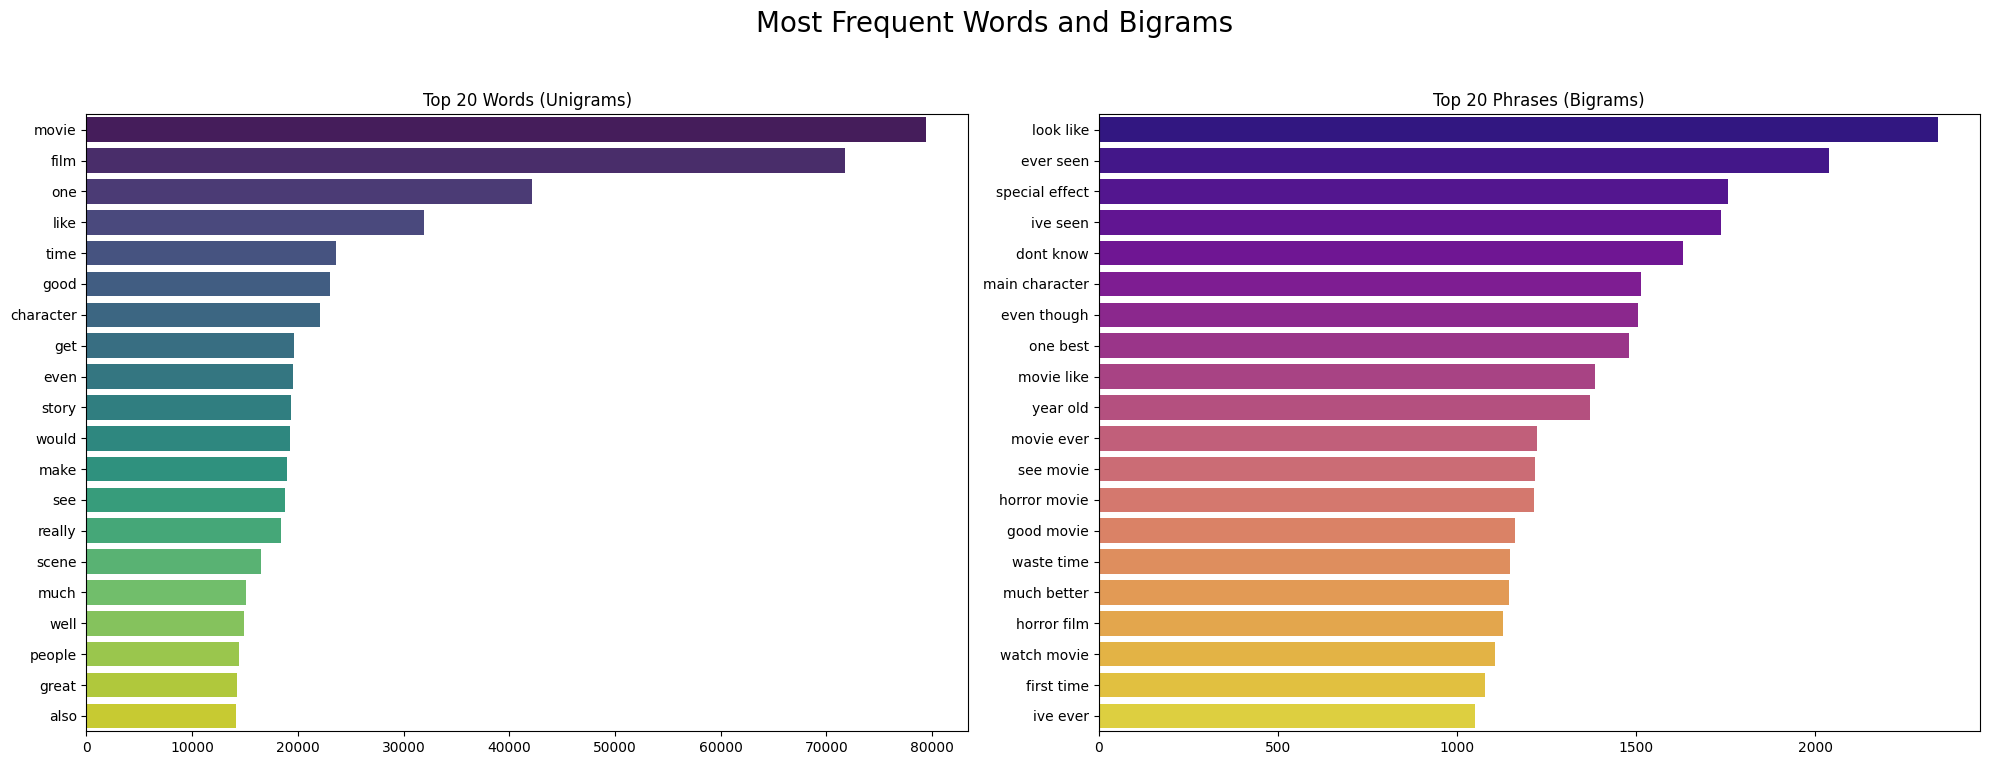

In [18]:
full_text = ' '.join(train_df['cleaned_text'])
tokens = full_text.split()

# Get frequency of words
word_counts = Counter(tokens)
top_words = word_counts.most_common(20)

# Get frequency of bigrams
bigram_counts = Counter(ngrams(tokens, 2))
top_bigrams = bigram_counts.most_common(20)

# Plotting the results
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Most Frequent Words and Bigrams', fontsize=20)

# Plot top words
words, counts = zip(*top_words)
sns.barplot(x=list(counts), y=list(words), ax=axes[0], palette='viridis')
axes[0].set_title('Top 20 Words (Unigrams)')

# Plot top bigrams
bigrams, counts = zip(*top_bigrams)
bigram_labels = [' '.join(bigram) for bigram in bigrams]
sns.barplot(x=list(counts), y=bigram_labels, ax=axes[1], palette='plasma')
axes[1].set_title('Top 20 Phrases (Bigrams)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Q5: Visualize Words Representing Positive and Negative Sentiment

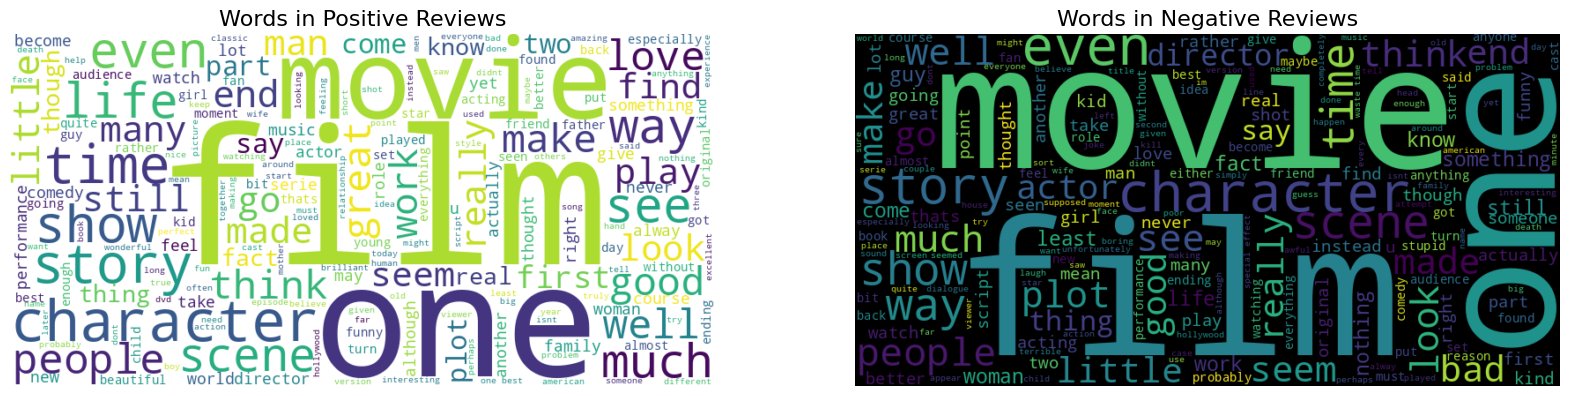

In [19]:
# Separate text based on sentiment (1 for positive, 0 for negative)
positive_text = ' '.join(train_df[train_df['label'] == 1]['cleaned_text'])
negative_text = ' '.join(train_df[train_df['label'] == 0]['cleaned_text'])

# Create word clouds
wc_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wc_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

# Plot the word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(wc_pos, interpolation='bilinear')
axes[0].set_title('Words in Positive Reviews', fontsize=16)
axes[0].axis('off')

axes[1].imshow(wc_neg, interpolation='bilinear')
axes[1].set_title('Words in Negative Reviews', fontsize=16)
axes[1].axis('off')

plt.show()

#### Q6a: Text Vectorization and Embedding Layer Setup

In [20]:
# Define vectorization parameters
vocab_size = 15000
embedding_dim = 128
max_length = 200

# Initialize and fit the tokenizer on the training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_text'])

# Convert text to padded sequences
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['cleaned_text']), maxlen=max_length)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_df['cleaned_text']), maxlen=max_length)
y_train = train_df['label'].values
y_val = val_df['label'].values

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

Training data shape: (40000, 200)
Validation data shape: (5000, 200)


#### Q6: Create, Build, and Train the RNN Models

In [29]:
# Build the 3-Layer LSTM model
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.4),
    LSTM(32, return_sequences=True),
    Dropout(0.3),
    LSTM(16),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Sigmoid for binary output (positive/negative)
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
print("\nTraining 3-Layer LSTM Model...")
history_lstm = model_lstm.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))

model_lstm.summary()


Training 3-Layer LSTM Model...
Epoch 1/10


/home/student/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7148 - loss: 0.5217 - val_accuracy: 0.8758 - val_loss: 0.2969
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9171 - loss: 0.2223 - val_accuracy: 0.8866 - val_loss: 0.2783
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9462 - loss: 0.1531 - val_accuracy: 0.8802 - val_loss: 0.3312
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9673 - loss: 0.0987 - val_accuracy: 0.8736 - val_loss: 0.3679
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9790 - loss: 0.0685 - val_accuracy: 0.8704 - val_loss: 0.4504
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9860 - loss: 0.0463 - val_accuracy: 0.8686 - val_loss: 0.5288
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9911 - loss: 0.0324 - val_accuracy: 0.8652 - val_loss: 0.6077
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9920 - loss: 0.0267 - val_accuracy: 0.86

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 200, 128)       │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 200, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 200, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,958,341 (22.73 MB)

 Trainable params: 1,986,113 (7.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,972,228 (15.15 MB)

In [30]:
# Build the 5-Layer Bidirectional RNN model
model_birnn = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(16)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_birnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
print("\nTraining 5-Layer Bidirectional RNN Model...")
history_birnn = model_birnn.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))
model_birnn.summary()


Training 5-Layer Bidirectional RNN Model...
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 73ms/step - accuracy: 0.7451 - loss: 0.4951 - val_accuracy: 0.8776 - val_loss: 0.2906
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.9246 - loss: 0.2088 - val_accuracy: 0.8872 - val_loss: 0.3064
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.9563 - loss: 0.1334 - val_accuracy: 0.8756 - val_loss: 0.3111
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.9695 - loss: 0.0989 - val_accuracy: 0.8748 - val_loss: 0.3810
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.9746 - loss: 0.0790 - val_accuracy: 0.8656 - val_loss: 0.4841
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.9858 - loss: 0.0504 - val_accuracy: 0.8686 - val_loss: 0.4846
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.9905 - loss: 0.0359 - val_accuracy: 0.8558 - val_loss: 0.4923
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 7

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 200, 128)       │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 200, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 200, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 200, 64)        │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 200, 64)        │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 32)             │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,588,677 (25.13 MB)

 Trainable params: 2,196,225 (8.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,392,452 (16.76 MB)

In [33]:
model_gru = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GRU(64, return_sequences=True), Dropout(0.4),
    GRU(32, return_sequences=True), Dropout(0.3),
    GRU(16),
    Dense(64, activation='relu'), Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("\n--- Training 3-Layer GRU Model ---")
history_gru = model_gru.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val), verbose=2)

model_gru.summary()


--- Training 3-Layer GRU Model ---
Epoch 1/10
313/313 - 11s - 34ms/step - accuracy: 0.7945 - loss: 0.4323 - val_accuracy: 0.8808 - val_loss: 0.2937
Epoch 2/10
313/313 - 7s - 23ms/step - accuracy: 0.9125 - loss: 0.2365 - val_accuracy: 0.8870 - val_loss: 0.2874
Epoch 3/10
313/313 - 7s - 23ms/step - accuracy: 0.9437 - loss: 0.1609 - val_accuracy: 0.8828 - val_loss: 0.3551
Epoch 4/10
313/313 - 7s - 23ms/step - accuracy: 0.9633 - loss: 0.1093 - val_accuracy: 0.8682 - val_loss: 0.3784
Epoch 5/10
313/313 - 7s - 23ms/step - accuracy: 0.9752 - loss: 0.0777 - val_accuracy: 0.8724 - val_loss: 0.4340
Epoch 6/10
313/313 - 7s - 23ms/step - accuracy: 0.9807 - loss: 0.0622 - val_accuracy: 0.8682 - val_loss: 0.5364
Epoch 7/10
313/313 - 7s - 23ms/step - accuracy: 0.9879 - loss: 0.0423 - val_accuracy: 0.8694 - val_loss: 0.6325
Epoch 8/10
313/313 - 7s - 23ms/step - accuracy: 0.9934 - loss: 0.0270 - val_accuracy: 0.8608 - val_loss: 0.6762
Epoch 9/10
313/313 - 7s - 23ms/step - accuracy: 0.9933 - loss: 0.02

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 200, 128)       │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 200, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 200, 32)        │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,910,629 (22.55 MB)

 Trainable params: 1,970,209 (7.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,940,420 (15.03 MB)

#### Q6: Visualize Model Performance

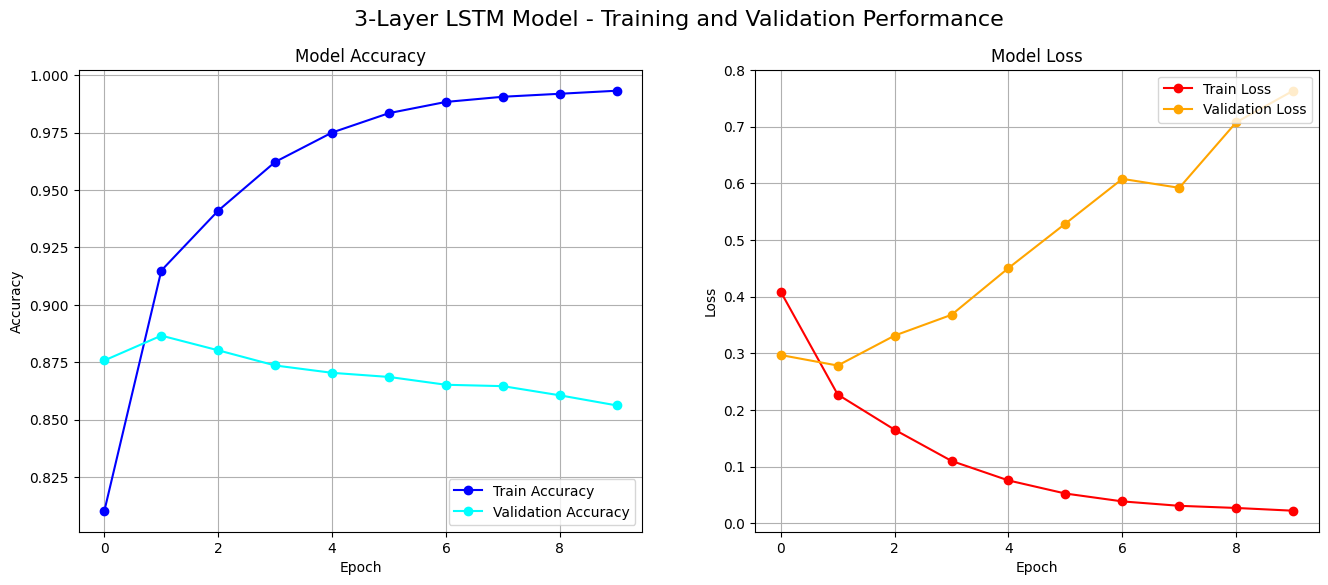

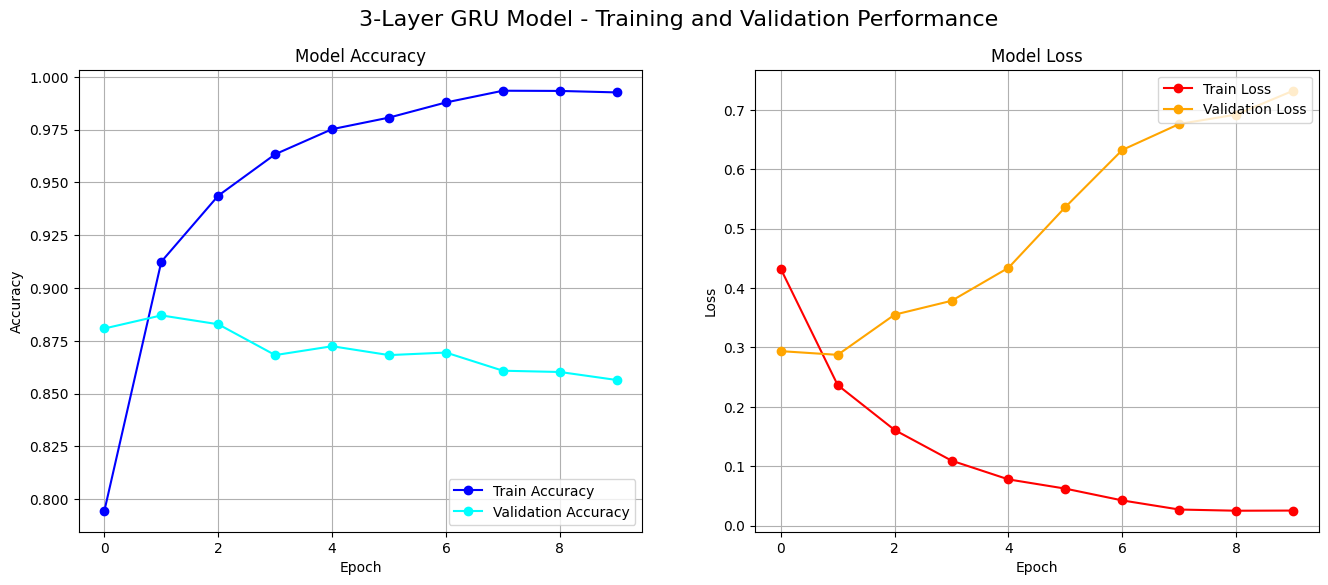

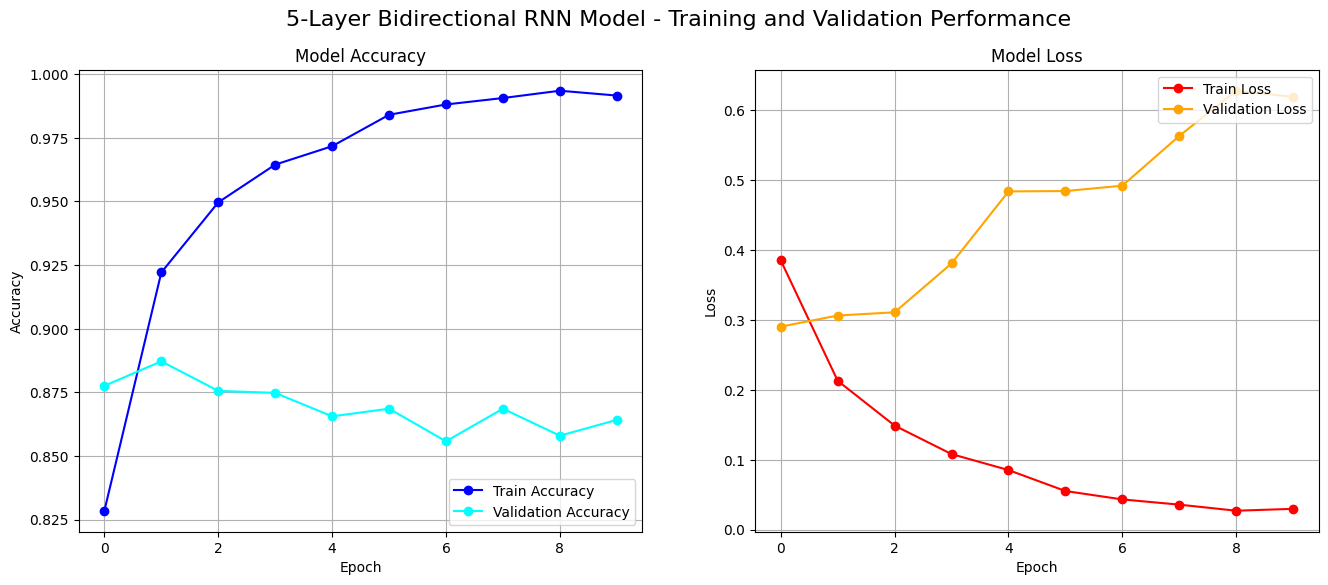

In [34]:
def plot_history(history, model_name):
    """
    Plots the training and validation accuracy and loss for a given model history.
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{model_name} - Training and Validation Performance', fontsize=16)

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'], label='Train Accuracy', color='blue', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan', marker='o')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # Plot training & validation loss values
    ax2.plot(history.history['loss'], label='Train Loss', color='red', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    
    plt.show()

# Visualize the performance of both models
plot_history(history_lstm, '3-Layer LSTM Model')
plot_history(history_gru, '3-Layer GRU Model')
plot_history(history_birnn, '5-Layer Bidirectional RNN Model')


#### Q7: Build a Custom Test Dataset and Tabulate Accuracy

In [35]:
custom_reviews = [
    "This movie was an absolute masterpiece, the acting was superb!",
    "I was incredibly bored. The plot was weak and predictable.",
    "A heartwarming and beautiful story. I loved every minute of it.",
    "Completely forgettable. Not terrible, but not good either.",
    "One of the worst films I have ever seen. A total disaster.",
]
actual_sentiments = np.array([1, 0, 1, 0, 0])
custom_cleaned = [preprocess_text(review) for review in custom_reviews]
custom_sequences = tokenizer.texts_to_sequences(custom_cleaned)
custom_padded = pad_sequences(custom_sequences, maxlen=max_length)

pred_lstm = (model_lstm.predict(custom_padded) > 0.5).astype(int).flatten()
pred_gru = (model_gru.predict(custom_padded) > 0.5).astype(int).flatten()
pred_birnn = (model_birnn.predict(custom_padded) > 0.5).astype(int).flatten()

results = pd.DataFrame({
    "Review": custom_reviews,
    "Actual": actual_sentiments,
    "Predicted (LSTM)": pred_lstm,
    "Predicted (GRU)": pred_gru,
    "Predicted (Bi-RNN)": pred_birnn
})
print("\n--- Model Performance on Custom Test Set ---")
print(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step

--- Model Performance on Custom Test Set ---
                                              Review  Actual  \
0  This movie was an absolute masterpiece, the ac...       1   
1  I was incredibly bored. The plot was weak and ...       0   
2  A heartwarming and beautiful story. I loved ev...       1   
3  Completely forgettable. Not terrible, but not ...       0   
4  One of the worst films I have ever seen. A tot...       0   

   Predicted (LSTM)  Predicted (GRU)  Predicted (Bi-RNN)  
0                 1                1                   1  
1                 0                0                   0  
2                 1                1                   1  
3                 0                0                   0  
4                 0                0                   0  
